<a href="https://colab.research.google.com/github/fagds/an_lise_trincas_ift_live_wire.ipynb/blob/main/Analise_trincas_IFT_com_LiveWire_RDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 319M/319M [00:15<00:00, 22.1MB/s]

Extracting files...


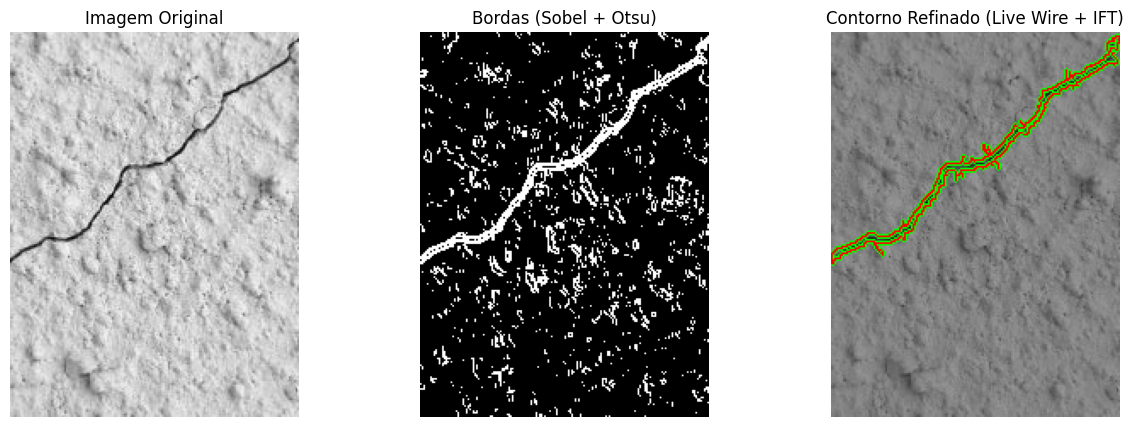

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Carregar imagem específica
image_path = "/root/.cache/kagglehub/datasets/oluwaseunad/concrete-and-pavement-crack-images/versions/1/Positive/06976.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {image_path}")

# Selecionar imagem aleatória
#random_image_path = os.path.join(image_dir, np.random.choice(image_files))
#image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
#if image is None:
#    raise ValueError(f"Erro ao carregar {random_image_path}")

# Carregamento da imagem
#image = cv2.imread(random_image_path)
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.axis("off")  # Remove os eixos para melhor visualização
#plt.show()
#print("Imagem carregada de:", random_image_path)

# Pré-processamento (Sobel + Otsu)
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Operações morfológicas para melhorar segmentação
kernel = np.ones((3, 3), np.uint8)
binary_morph = cv2.dilate(binary, kernel, iterations=1)

# Criar cópia para exibição dos contornos
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Extrair contornos iniciais
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Refinar contornos com Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)

    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        new_points.append(refined_contour[-1])
        refined_contour = np.array(new_points)
    return refined_contour

# Aplicar refinamento
refined_contours = [iterative_live_wire_ift(image, c, iterations=5) for c in contours]

# Desenhar pontos intermediários
for contour in refined_contours:
    for point in contour:
        cv2.circle(contour_image, tuple(point), 1, (0, 255, 0), 1)  # Verde para pontos

# Desenhar contornos refinados
for contour in refined_contours:
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)  # Azul

# Exibir os resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Imagem Original")
plt.imshow(image, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Bordas (Sobel + Otsu)")
plt.imshow(binary, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Contorno Refinado (Live Wire + IFT)")
plt.imshow(contour_image)
plt.axis("off")

plt.show()



100%|██████████| 319M/319M [00:16<00:00, 20.1MB/s]

Extracting files...


Número de pontos no contorno: 2554


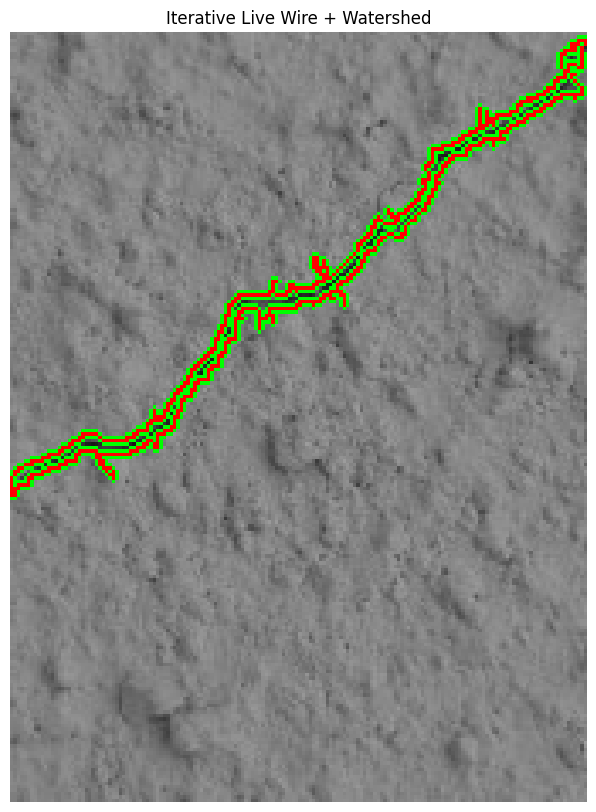

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
#random_image_path = os.path.join(image_dir, np.random.choice(image_files))
#image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
# Carregar imagem específica
image_path = "/root/.cache/kagglehub/datasets/oluwaseunad/concrete-and-pavement-crack-images/versions/1/Positive/06976.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {image_path}")

edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Refinamento com Live Wire a partir da borda do Watershed
def iterative_live_wire_from_watershed(image, initial_contour, iterations=3):
    refined_contour = np.array(initial_contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

refined_contours = [iterative_live_wire_from_watershed(image, c) for c in contours]

contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for contour in refined_contours:
    for point in contour:
        cv2.circle(contour_image, tuple(point), 1, (0, 255, 0), 1)
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)
    print(f"Número de pontos no contorno: {len(contour)}")

plt.figure(figsize=(10, 10))
plt.imshow(contour_image)
plt.title("Iterative Live Wire + Watershed")
plt.axis("off")
plt.show()


Número de pontos no contorno simplificado: 61


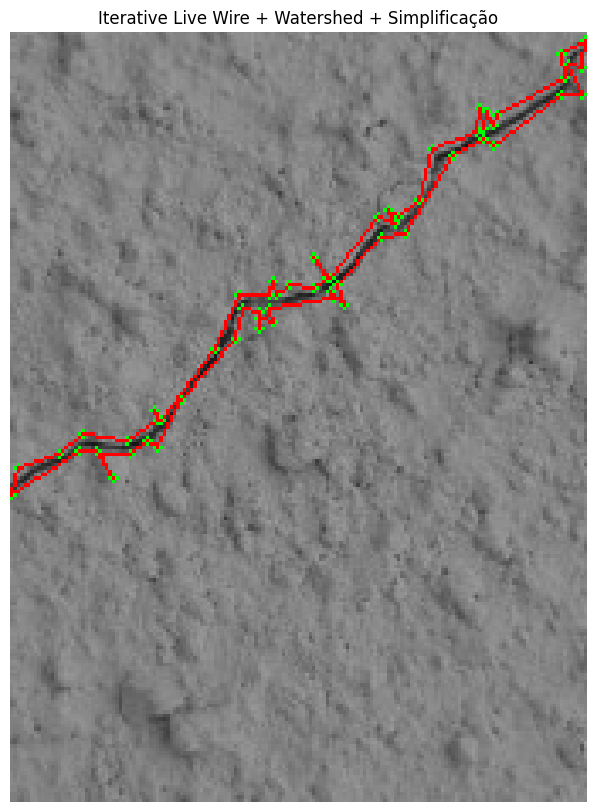

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
#random_image_path = os.path.join(image_dir, np.random.choice(image_files))
#image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
# Carregar imagem específica
image_path = "/root/.cache/kagglehub/datasets/oluwaseunad/concrete-and-pavement-crack-images/versions/1/Positive/06976.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {image_path}")

edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Refinamento com Live Wire a partir da borda do Watershed
def iterative_live_wire_from_watershed(image, initial_contour, iterations=3):
    refined_contour = np.array(initial_contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

refined_contours = [iterative_live_wire_from_watershed(image, c) for c in contours]

# Função para reduzir pontos do contorno usando Ramer-Douglas-Peucker
def simplify_contour(contour, epsilon=2.0):
    return cv2.approxPolyDP(contour, epsilon, True)

simplified_contours = [simplify_contour(c, epsilon=2.0) for c in refined_contours]

contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for contour in simplified_contours:
    for point in contour:
        cv2.circle(contour_image, tuple(point[0]), 1, (0, 255, 0), 1)
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)
    print(f"Número de pontos no contorno simplificado: {len(contour)}")

plt.figure(figsize=(10, 10))
plt.imshow(contour_image)
plt.title("Iterative Live Wire + Watershed + Simplificação")
plt.axis("off")
plt.show()

In [6]:
!pip install scikit-image==0.19.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 116.0 MB/s eta 0:00:00
  Created wheel for scikit-image: filename=scikit_image-0.19.3-cp311-cp311-linux_x86_64.whl size=33913458 sha256=52973fc28f593b45eba24b1ef2c2d072f16a01837086c9f8484396458ef6ab2f
  Stored in directory: /root/.cache/pip/wheels/7b/12/cd/f311cabf9e8708d1e29e9951ee0839fb89b69e1acc60c94927
Successfully built scikit-image
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.1
    Uninstalling scikit-image-0.25.1:
      Successfully uninstalled scikit-image-0.25.1


<ipython-input-2-05f831123491>:55: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  snake = active_contour(


Número de pontos após Snake e RDP: 28


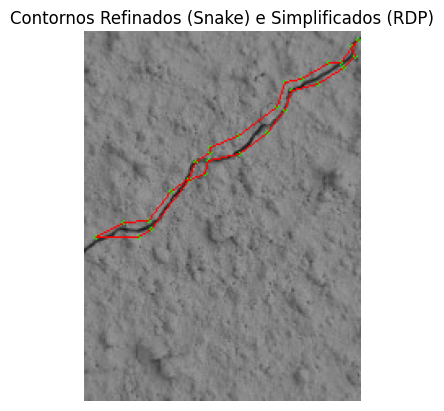

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub
from skimage.segmentation import active_contour

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
#random_image_path = os.path.join(image_dir, np.random.choice(image_files))
#image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
# Carregar imagem específica
image_path = "/root/.cache/kagglehub/datasets/oluwaseunad/concrete-and-pavement-crack-images/versions/1/Positive/06976.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {image_path}")

# Watershed para segmentação inicial
#edges = sobel(image)
#thresh_value = threshold_otsu(edges)
#binary = (edges > thresh_value).astype(np.uint8) * 255

#distance = distance_transform_edt(binary)
#local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
#markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
#labels = watershed(-distance, markers, mask=binary)

# Watershed para segmentação inicial
edges = sobel(image)
#edges = cv2.Canny(image, 50, 150)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8)

distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Extrair contornos iniciais do watershed
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Função para converter contorno OpenCV para formato Snake (numpy array de float)
def contour_to_snake_points(contour):
    return np.array(contour[:, 0, :], dtype=np.float64)

def refine_with_snake(image, initial_contour, edge_image, iterations=250):
    snake = active_contour(
        image=edge_image,  # Campo de energia - bordas
        snake=initial_contour,
        alpha=0.01,  # Peso da suavidade
        beta=0.01,  # Peso da rigidez
        gamma=0.01,  # Passo da evolução
        max_iterations=iterations,
        w_line=0,  # Ignorar intensidade, usar apenas gradiente
        w_edge=1  # Focar em bordas

    )
    return snake

snake_contours = []
for contour in contours:
    initial_snake = contour_to_snake_points(contour)
    snake_contour = refine_with_snake(image, initial_snake, edges)
    snake_contours.append(snake_contour)

# Ramer-Douglas-Peucker para simplificação final
def simplify_contour(contour, epsilon=2.0):
    contour_int = np.array(contour, dtype=np.int32)
    return cv2.approxPolyDP(contour_int, epsilon, True)

simplified_contours = [simplify_contour(c, epsilon=2.0) for c in snake_contours]

# Visualização final
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for contour in simplified_contours:
    for point in contour:
        cv2.circle(contour_image, tuple(point[0]), 1, (0, 255, 0), 1)
    cv2.drawContours(contour_image, [contour], -1, (255, 0, 0), 1)
    print(f"Número de pontos após Snake e RDP: {len(contour)}")

plt.imshow(contour_image)
plt.title('Contornos Refinados (Snake) e Simplificados (RDP)')
plt.axis('off')
plt.show()


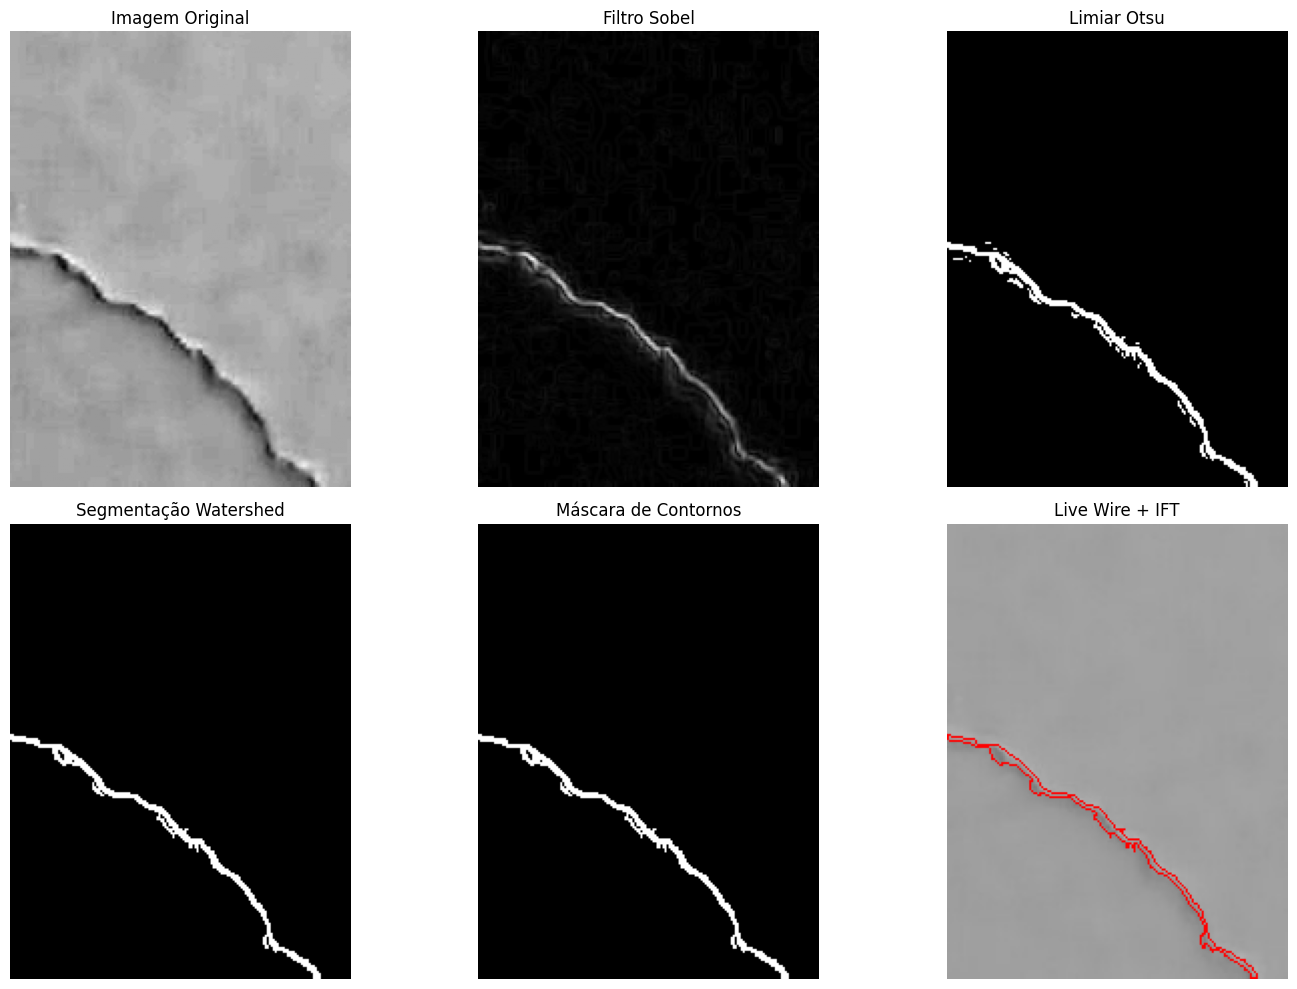

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Selecionar imagem aleatória
random_image_path = os.path.join(image_dir, np.random.choice(image_files))
image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {random_image_path}")

# Aplicar Sobel para realçar contornos
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Criar máscara de contornos
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Refinar contornos com Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

# Aplicar refinamento
refined_contours = [iterative_live_wire_ift(image, c) for c in contours]

# Desenhar contornos refinados
for contour in refined_contours:
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)  # Azul

# Plotagem Comparativa
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Imagem Original")
axes[0, 1].imshow(edges, cmap='gray')
axes[0, 1].set_title("Filtro Sobel")
axes[0, 2].imshow(binary, cmap='gray')
axes[0, 2].set_title("Limiar Otsu")
axes[1, 0].imshow(labels, cmap='gray')
axes[1, 0].set_title("Segmentação Watershed")
axes[1, 1].imshow(mask, cmap='gray')
axes[1, 1].set_title("Máscara de Contornos")
axes[1, 2].imshow(contour_image)
axes[1, 2].set_title("Live Wire + IFT")
for ax in axes.ravel():
    ax.axis("off")
plt.tight_layout()

# Exibir os resultados
plt.show()


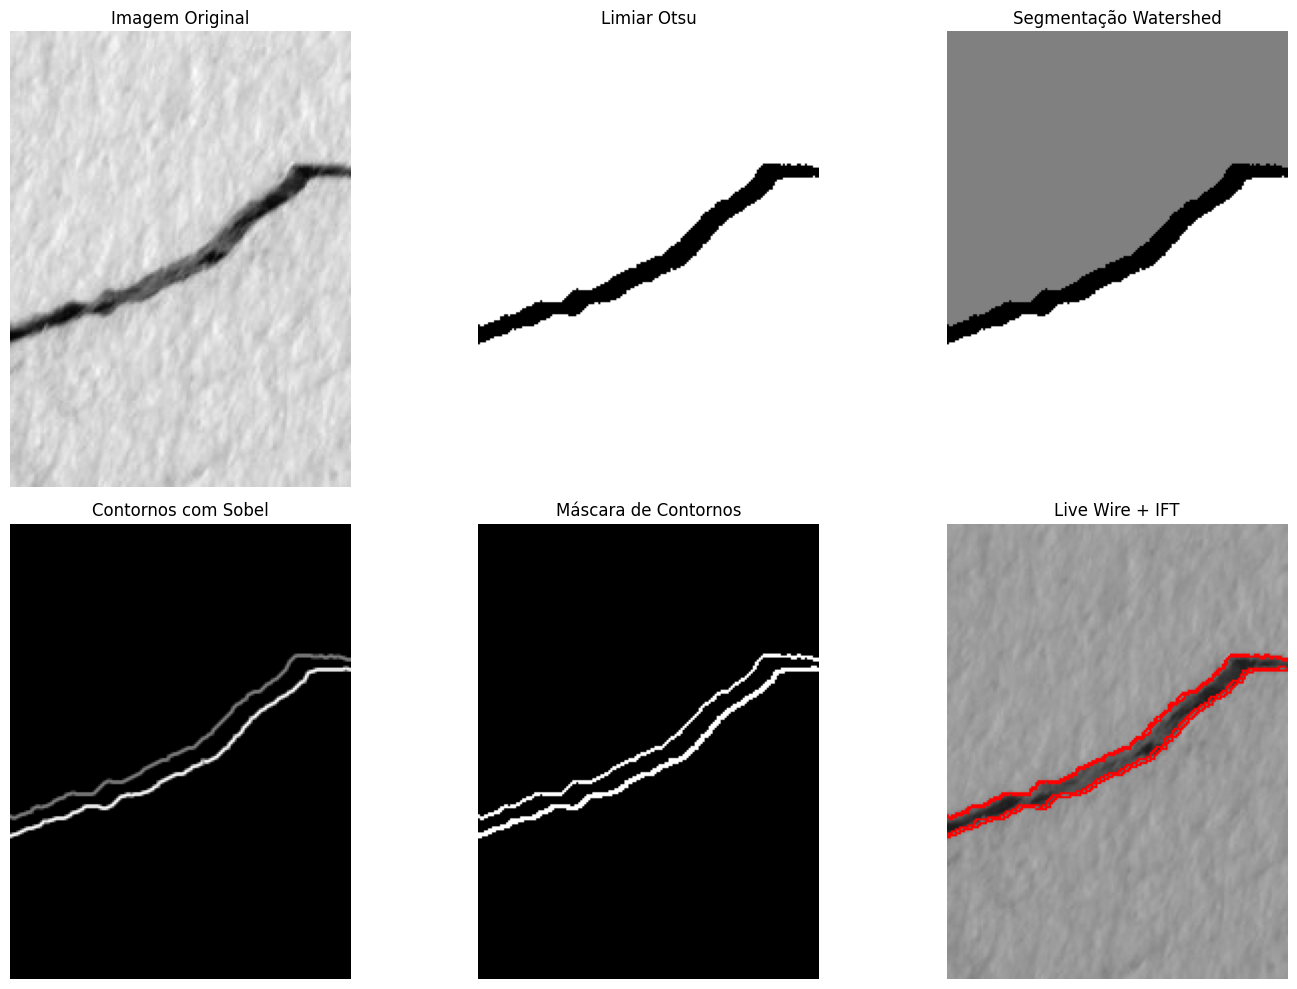

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Selecionar imagem aleatória
random_image_path = os.path.join(image_dir, np.random.choice(image_files))
image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {random_image_path}")

# Watershed para segmentação inicial
thresh_value = threshold_otsu(image)
binary = (image > thresh_value).astype(np.uint8) * 255
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Aplicar Sobel para realçar contornos
edges = sobel(labels.astype(np.uint8))
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Criar máscara de contornos
mask = (edges > threshold_otsu(edges)).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Refinar contornos com Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

# Aplicar refinamento
refined_contours = [iterative_live_wire_ift(image, c) for c in contours]

# Desenhar contornos refinados
for contour in refined_contours:
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)  # Azul

# Plotagem Comparativa
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Imagem Original")
axes[0, 1].imshow(binary, cmap='gray')
axes[0, 1].set_title("Limiar Otsu")
axes[0, 2].imshow(labels, cmap='gray')
axes[0, 2].set_title("Segmentação Watershed")
axes[1, 0].imshow(edges, cmap='gray')
axes[1, 0].set_title("Contornos com Sobel")
axes[1, 1].imshow(mask, cmap='gray')
axes[1, 1].set_title("Máscara de Contornos")
axes[1, 2].imshow(contour_image)
axes[1, 2].set_title("Live Wire + IFT")
for ax in axes.ravel():
    ax.axis("off")
plt.tight_layout()

# Exibir os resultados
plt.show()


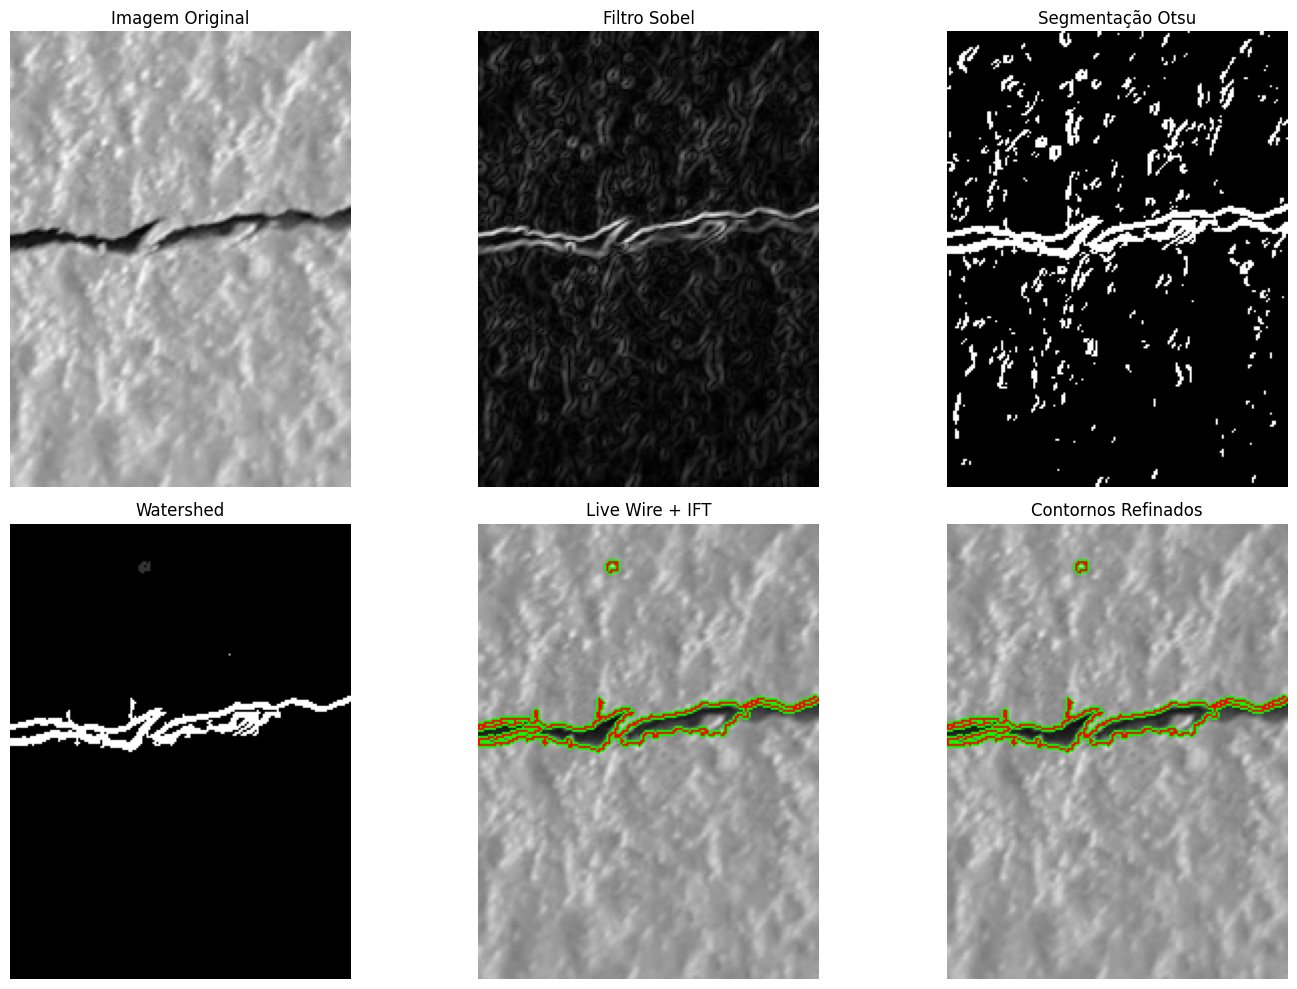

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Selecionar imagem aleatória
random_image_path = os.path.join(image_dir, np.random.choice(image_files))
image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {random_image_path}")

# Pré-processamento (Sobel + Otsu)
edges = sobel(image)
thresh_value = threshold_otsu(edges)  # Aplicando Otsu nas bordas
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Refinamento com Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

# Extração de contornos iniciais
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Aplicar refinamento
refined_contours = [iterative_live_wire_ift(image, c) for c in contours]

# Criar cópia da imagem para exibição dos contornos
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Desenhar pontos intermediários
for contour in refined_contours:
    for point in contour:
        cv2.circle(contour_image, tuple(point), 1, (0, 255, 0), 1)  # Verde para pontos

# Desenhar contornos refinados
for contour in refined_contours:
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)  # Azul

# Plotagem Comparativa
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Imagem Original")
axes[0, 1].imshow(edges, cmap='gray')
axes[0, 1].set_title("Filtro Sobel")
axes[0, 2].imshow(binary, cmap='gray')
axes[0, 2].set_title("Segmentação Otsu")
axes[1, 0].imshow(labels, cmap='gray')
axes[1, 0].set_title("Watershed")
axes[1, 1].imshow(contour_image)
axes[1, 1].set_title("Live Wire + IFT")
axes[1, 2].imshow(contour_image)
axes[1, 2].set_title("Contornos Refinados")
for ax in axes.ravel():
    ax.axis("off")
plt.tight_layout()

# Exibir os resultados
plt.show()


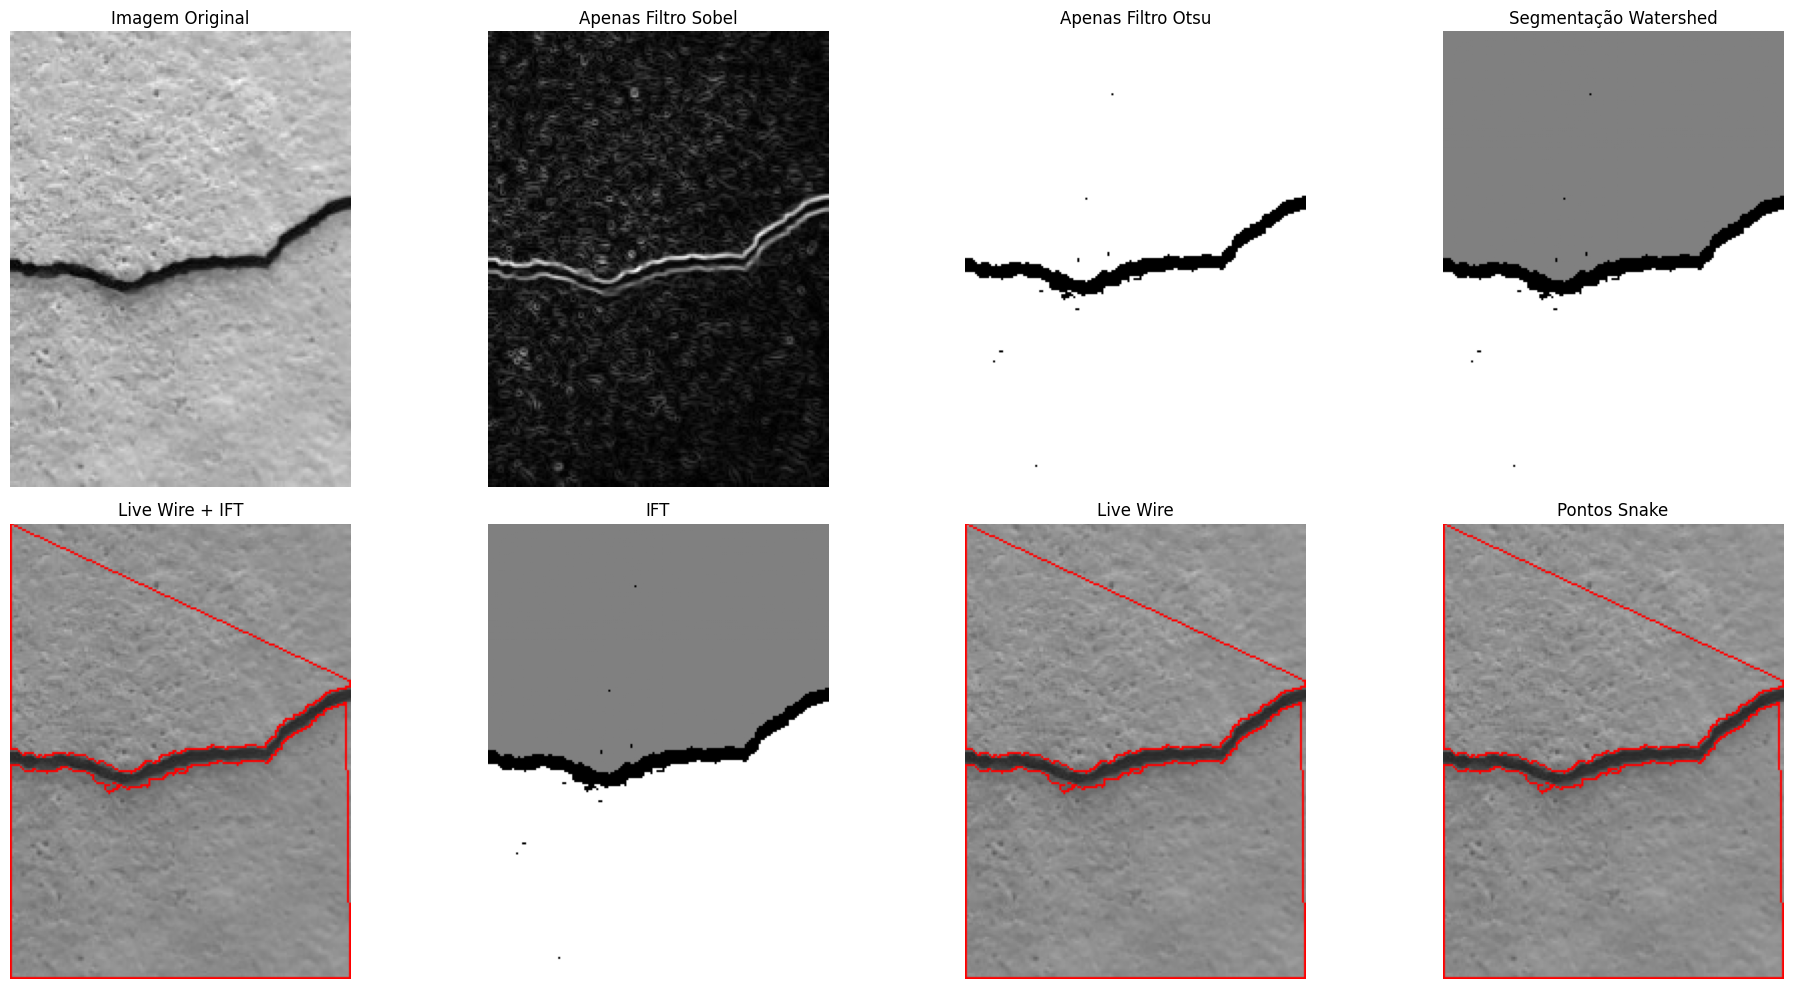

<Figure size 1500x500 with 0 Axes>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Selecionar imagem aleatória
random_image_path = os.path.join(image_dir, np.random.choice(image_files))
image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {random_image_path}")

# Pré-processamento (Sobel + Otsu)
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Operações morfológicas para melhorar segmentação
kernel = np.ones((3, 3), np.uint8)
binary_morph = cv2.dilate(binary, kernel, iterations=1)

# Criar cópia para exibição dos contornos
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Extrair contornos iniciais
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Refinar contornos com Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)

    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        new_points.append(refined_contour[-1])
        refined_contour = np.array(new_points)
    return refined_contour

# Aplicar refinamento
refined_contours = [iterative_live_wire_ift(image, c, iterations=5) for c in contours]

# Desenhar pontos intermediários
for contour in refined_contours:
    for point in contour:
        cv2.circle(contour_image, tuple(point), 1, (0, 255, 0), 1)  # Verde para pontos

# Desenhar contornos refinados
for contour in refined_contours:
    cv2.drawContours(contour_image, [contour.astype(np.int32)], -1, (255, 0, 0), 1)  # Azul

# Pré-processamento (Sobel + Otsu)
edges_sobel = sobel(image)
thresh_value = threshold_otsu(image)  # O limiar é calculado na imagem original, não em 'edges'
edges_otsu = (image > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(edges_otsu)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=edges_otsu)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels_watershed = watershed(-distance, markers, mask=edges_otsu)

# Criar cópia para exibição dos contornos
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Função para Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

# Aplicar Iterative Live Wire + IFT
contours, _ = cv2.findContours(edges_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refined_contours = [iterative_live_wire_ift(image, c) for c in contours]
cv2.drawContours(contour_image, refined_contours, -1, (255, 0, 0), 1)

# Plotagem Comparativa
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Imagem Original")
axes[0, 1].imshow(edges_sobel, cmap='gray')
axes[0, 1].set_title("Apenas Filtro Sobel")
axes[0, 2].imshow(edges_otsu, cmap='gray')
axes[0, 2].set_title("Apenas Filtro Otsu")
axes[0, 3].imshow(labels_watershed, cmap='gray')
axes[0, 3].set_title("Segmentação Watershed")
axes[1, 0].imshow(contour_image)
axes[1, 0].set_title("Live Wire + IFT")
axes[1, 1].imshow(labels_watershed, cmap='gray')
axes[1, 1].set_title("IFT")
axes[1, 2].imshow(contour_image)
axes[1, 2].set_title("Live Wire")
axes[1, 3].imshow(contour_image)
axes[1, 3].set_title("Pontos Snake")
for ax in axes.ravel():
    ax.axis("off")
plt.tight_layout()

# Exibir os resultados
plt.figure(figsize=(15, 5))

plt.show()

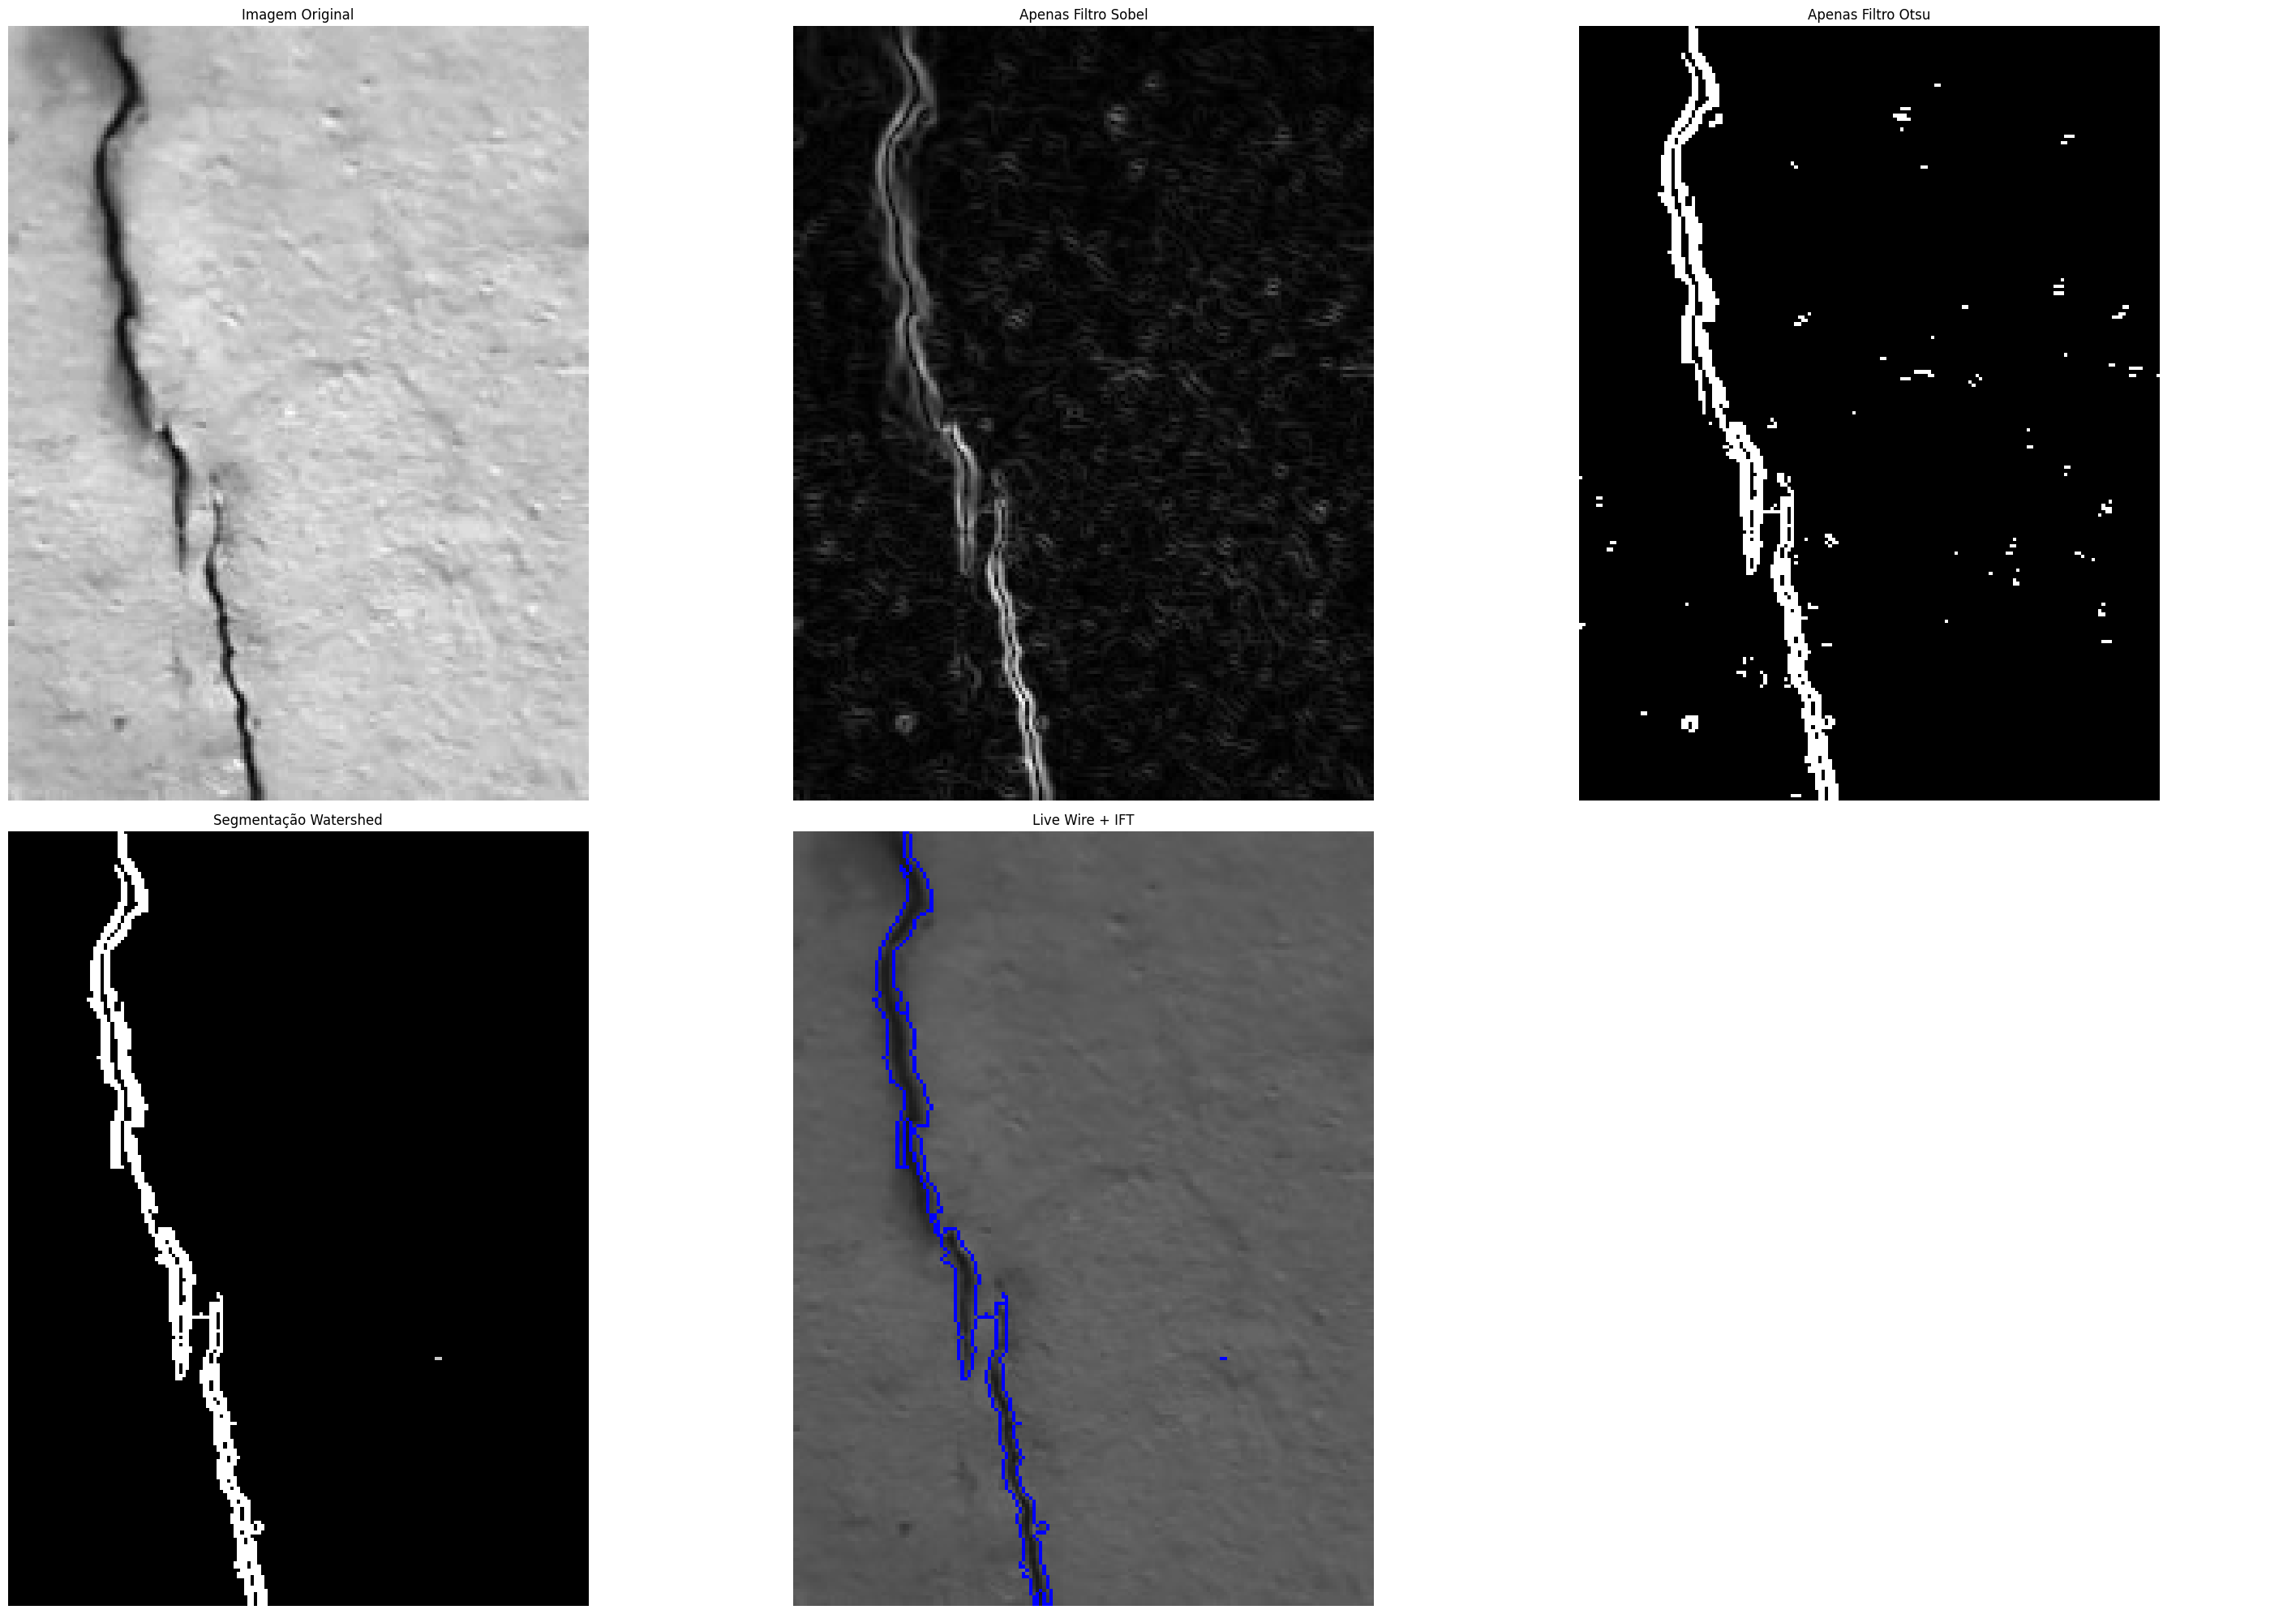

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Selecionar imagem aleatória
random_image_path = os.path.join(image_dir, np.random.choice(image_files))
image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {random_image_path}")

# Pré-processamento (Sobel + Otsu)
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Operações morfológicas para melhorar segmentação
kernel = np.ones((3, 3), np.uint8)
binary_morph = cv2.dilate(binary, kernel, iterations=1)

# Criar cópias para exibição dos contornos
contour_image_live_wire = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
contour_image_ift = contour_image_live_wire.copy()
contour_image_snake = contour_image_live_wire.copy()

# Extrair contornos iniciais
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Aqui entrariam as implementações dos refinamentos (Live Wire, IFT, Snake)
# Exemplo fictício: aplicar cor vermelha nos contornos
cv2.drawContours(contour_image_live_wire, contours, -1, (0, 0, 255), 1)
cv2.drawContours(contour_image_ift, contours, -1, (0, 0, 255), 1)
cv2.drawContours(contour_image_snake, contours, -1, (0, 0, 255), 1)

# Criar figura para exibição
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
axes = axes.ravel()

# Exibir imagens corretamente
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Imagem Original")

axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Apenas Filtro Sobel")

axes[2].imshow(binary, cmap='gray')
axes[2].set_title("Apenas Filtro Otsu")

axes[3].imshow(labels, cmap='gray')
axes[3].set_title("Segmentação Watershed")

axes[4].imshow(contour_image_live_wire)
axes[4].set_title("Live Wire + IFT")

# Ajustar layout e exibir
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()


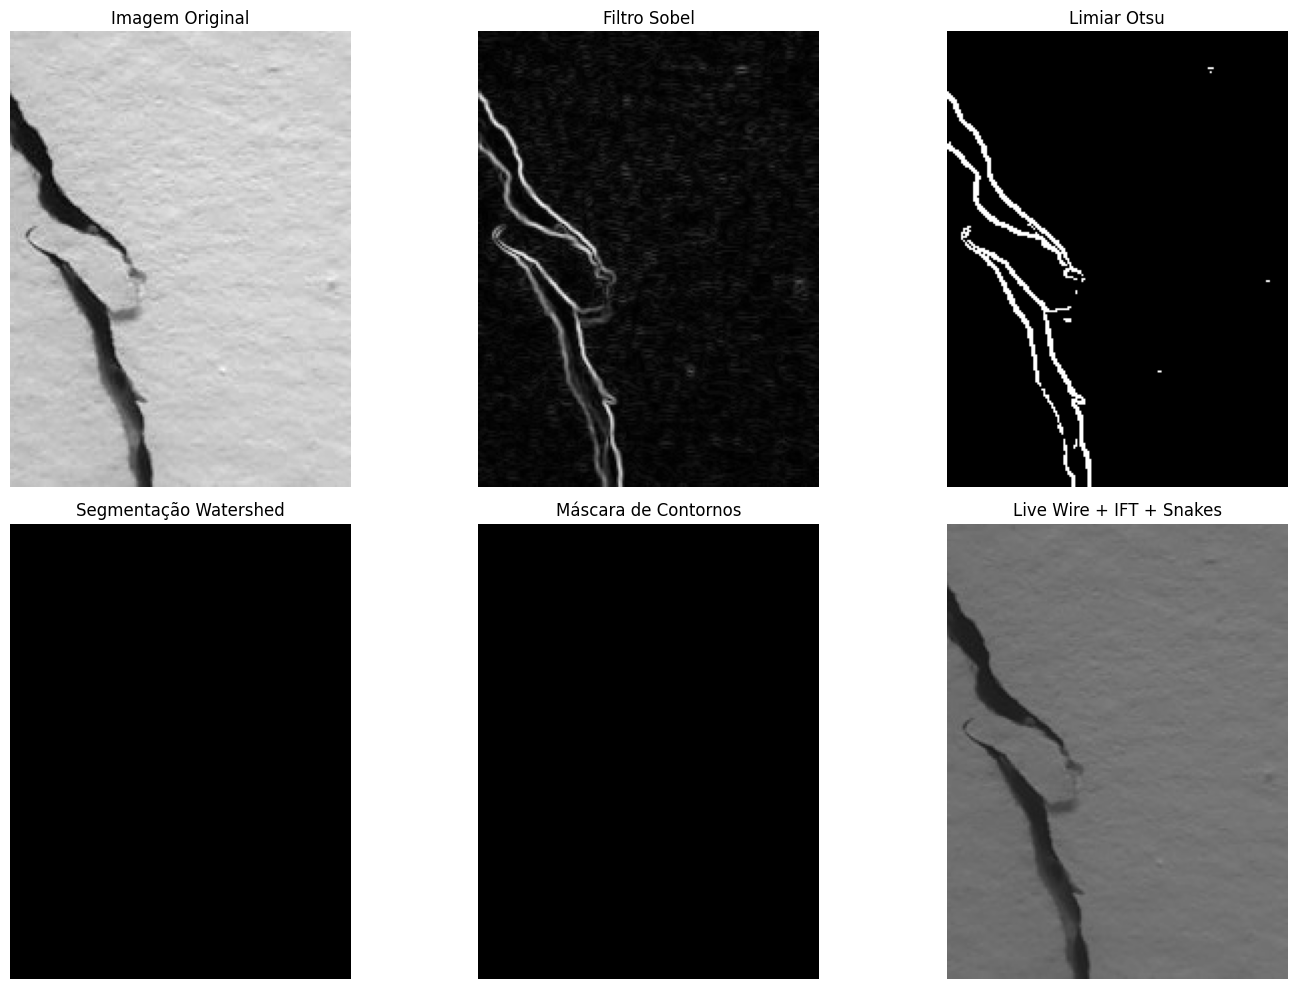

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed, active_contour
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Selecionar imagem aleatória
random_image_path = os.path.join(image_dir, np.random.choice(image_files))
image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {random_image_path}")

# Aplicar Sobel para realçar contornos
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Criar máscara de contornos
mask = (labels > 0).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Refinar contornos com Iterative Live Wire + IFT
def iterative_live_wire_ift(image, contour, iterations=5):
    refined_contour = np.array(contour).reshape(-1, 2)
    for _ in range(iterations):
        new_points = []
        for i in range(len(refined_contour) - 1):
            p1, p2 = refined_contour[i], refined_contour[i + 1]
            new_p = (p1 + p2) // 2  # Ponto intermediário
            new_points.append(p1)
            new_points.append(new_p)
        refined_contour = np.array(new_points)
    return refined_contour

# Aplicar refinamento
refined_contours = [iterative_live_wire_ift(image, c) for c in contours]

# Aplicar Active Contour (Snakes)
for contour in refined_contours:
    contour = contour.squeeze()
    snake = active_contour(edges, contour, alpha=0.1, beta=0.1, gamma=0.01)
    cv2.drawContours(contour_image, [snake.astype(np.int32)], -1, (0, 255, 0), 1)  # Verde para Snakes

# Plotagem Comparativa
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Imagem Original")
axes[0, 1].imshow(edges, cmap='gray')
axes[0, 1].set_title("Filtro Sobel")
axes[0, 2].imshow(binary, cmap='gray')
axes[0, 2].set_title("Limiar Otsu")
axes[1, 0].imshow(labels, cmap='gray')
axes[1, 0].set_title("Segmentação Watershed")
axes[1, 1].imshow(mask, cmap='gray')
axes[1, 1].set_title("Máscara de Contornos")
axes[1, 2].imshow(contour_image)
axes[1, 2].set_title("Live Wire + IFT + Snakes")
for ax in axes.ravel():
    ax.axis("off")
plt.tight_layout()

# Exibir os resultados
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")

# Filtrar imagens válidas
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Carregar imagem específica
image_path = "/root/.cache/kagglehub/datasets/oluwaseunad/concrete-and-pavement-crack-images/versions/1/Positive/06976.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {image_path}")

# Pré-processamento (Sobel + Otsu)
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Watershed para segmentação inicial
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# ... (rest of the image processing code) ...


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import numpy as np

def calculate_segmentation_metrics(ground_truth, segmentation, labels): # Pass labels as an argument
    """
    Calculate segmentation metrics.

    Args:
        ground_truth: The ground truth segmentation.
        segmentation: The predicted segmentation.
        labels: The 'labels' variable containing the output of the segmentation for the specific image.

    Returns:
        Tuple: Accuracy, precision, recall, F1-score, and IoU.
    """
    # Converter para binário (0 e 1) se não estiver
    ground_truth_image = cv2.imread("/root/.cache/kagglehub/datasets/oluwaseunad/concrete-and-pavement-crack-images/versions/1/Positive/00001.jpg", cv2.IMREAD_GRAYSCALE)
    if ground_truth_image is None:
        raise ValueError(f"Erro ao carregar a imagem de ground truth")

    segmentation_result = labels  # Use the 'labels' variable passed as argument

    # Ensure ground_truth_image and segmentation_result are binary
    ground_truth_binary = (ground_truth_image > 0).astype(int)
    segmentation_binary = (segmentation_result > 0).astype(int)

    # Cálculo das métricas
    accuracy = accuracy_score(ground_truth_binary.flatten(), segmentation_binary.flatten())
    precision = precision_score(ground_truth_binary.flatten(), segmentation_binary.flatten())
    recall = recall_score(ground_truth_binary.flatten(), segmentation_binary.flatten())
    f1 = f1_score(ground_truth_binary.flatten(), segmentation_binary.flatten())
    iou = jaccard_score(ground_truth_binary.flatten(), segmentation_binary.flatten())

    return accuracy, precision, recall, f1, iou

ground_truth_image = cv2.imread("caminho_para_ground_truth.jpg", cv2.IMREAD_GRAYSCALE)  # Substitua 'caminho_para_ground_truth.jpg'
segmentation_result = labels  # Ou os contornos refinados obtidos pelo seu algoritmo


# Calcular as métricas de avaliação, passing 'labels' to the function
accuracy, precision, recall, f1, iou = calculate_segmentation_metrics(ground_truth_image, segmentation_result, labels)

# Exibir os resultados das métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Índice de Jaccard (IoU): {iou:.4f}")

100%|██████████| 319M/319M [00:06<00:00, 54.0MB/s]

Extracting files...


Acurácia: 0.0295
Precisão: 1.0000
Revocação: 0.0295
F1-Score: 0.0572
Índice de Jaccard (IoU): 0.0295


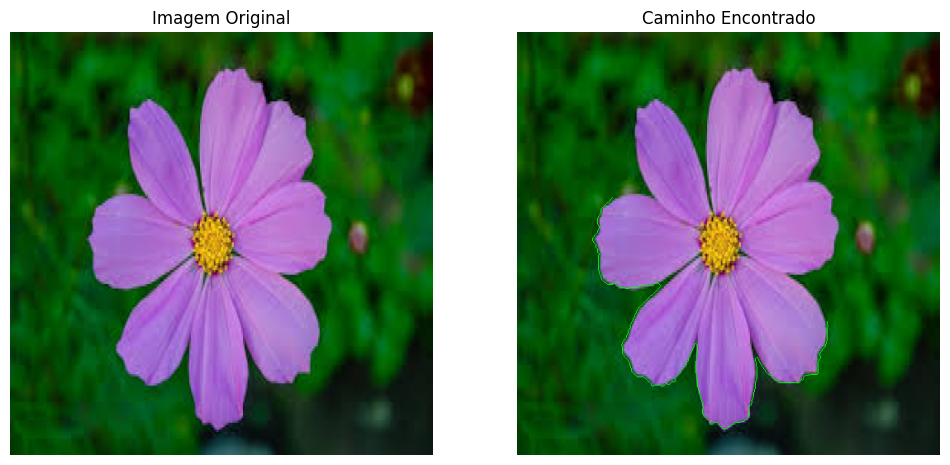

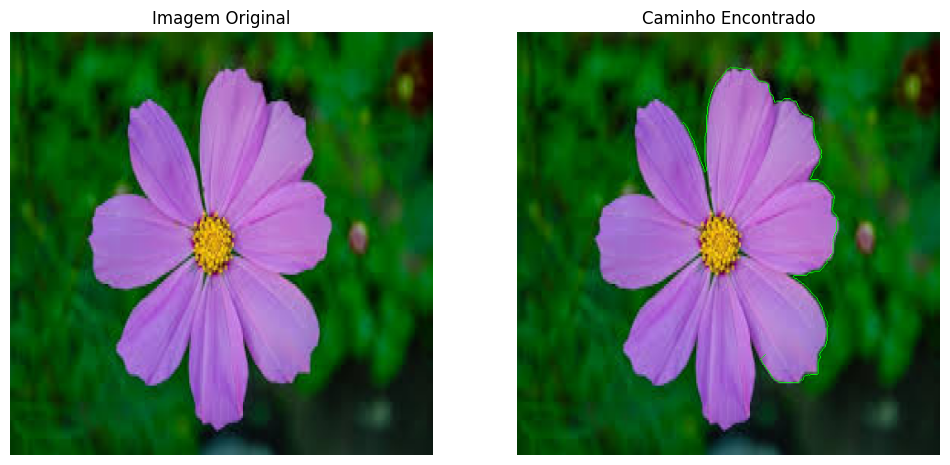

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush


# Função para carregar e redimensionar a imagem
def load_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Erro ao carregar a imagem: {image_path}")
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return image


# Função de pré-processamento aprimorada
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.bilateralFilter(equalized, d=9, sigmaColor=75, sigmaSpace=75)

    # Gradientes Sobel e Canny
    grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = cv2.magnitude(grad_x, grad_y)
    grad_magnitude = cv2.normalize(grad_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    edges = cv2.Canny(grad_magnitude.astype(np.uint8), 50, 150)
    return edges


# Construção do grafo
def build_graph(image):
    rows, cols = image.shape
    indices = np.arange(rows * cols).reshape(rows, cols)
    graph = {i: [] for i in range(rows * cols)}

    for r in range(rows):
        for c in range(cols):
            current_index = indices[r, c]
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    neighbor_index = indices[nr, nc]
                    weight = 1 + (255 - image[nr, nc])  # Priorizar bordas fortes
                    graph[current_index].append((neighbor_index, weight))
    return graph


# Algoritmo Dijkstra
def shortest_path_sparse(graph, start, end):
    pq = [(0, start)]  # Fila de prioridades
    distances = {start: 0}
    predecessors = {}

    while pq:
        current_distance, current_node = heappop(pq)

        if current_node == end:
            break

        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight
            if neighbor not in distances or distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heappush(pq, (distance, neighbor))

    # Reconstruir o caminho
    path = []
    while end is not None:
        path.append(end)
        end = predecessors.get(end)
    return path[::-1]


# Função para visualizar o resultado
def visualize_path(image, path, indices, output_path=None):
    rows, cols = image.shape[:2]
    path_image = image.copy()
    for node in path:
        r, c = divmod(node, cols)
        path_image[r, c] = (0, 255, 0)  # Marcar o caminho em verde

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Imagem Original")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Caminho Encontrado")
    plt.imshow(cv2.cvtColor(path_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    if output_path:
        cv2.imwrite(output_path, path_image)


# Função principal
def main(image_path, start_point, end_point, output_path=None):
    # Carregar imagem
    image = load_image(image_path)

    # Pré-processar
    edges = preprocess_image(image)

    # Construir grafo
    graph = build_graph(edges)

    # Calcular índices
    rows, cols = edges.shape
    start_index = start_point[0] * cols + start_point[1]
    end_index = end_point[0] * cols + end_point[1]

    # Executar Dijkstra
    path = shortest_path_sparse(graph, start_index, end_index)

    # Visualizar resultado
    visualize_path(image, path, edges, output_path)


# Exemplo de uso
main("/content/flor1.jpg", start_point=(200, 115), end_point=(350, 375), output_path="saida.jpg")
main("/content/flor1.jpg", start_point=(110, 200), end_point=(390, 300), output_path="saida.jpg")


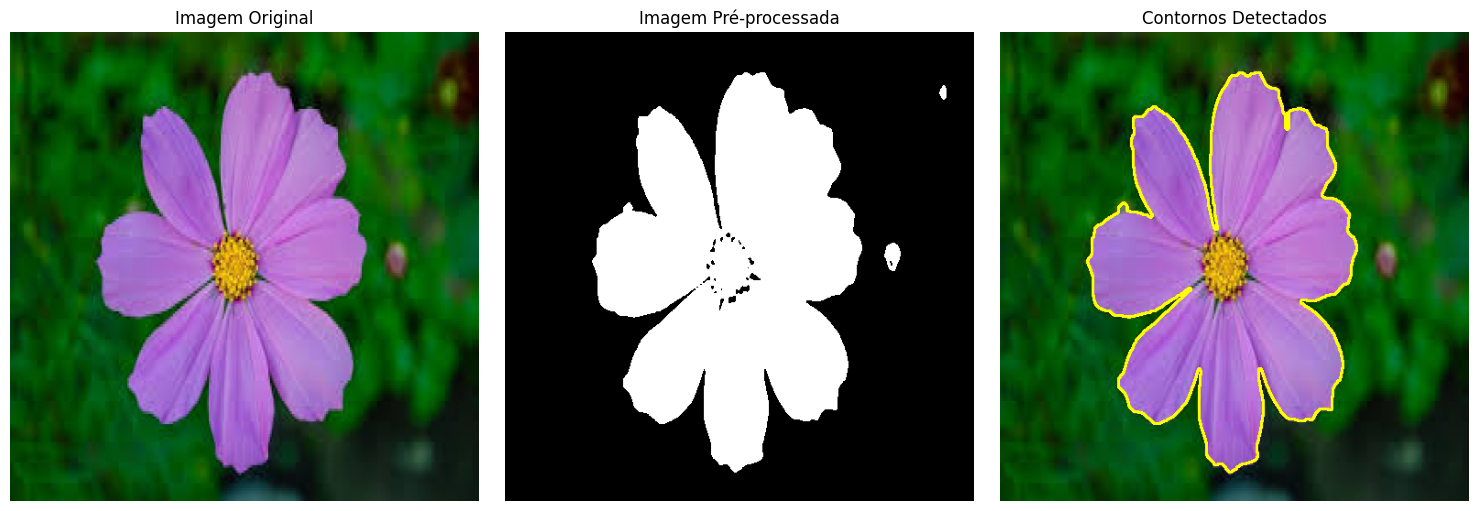

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt

# Função para carregar e redimensionar a imagem
def load_and_resize_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Erro ao carregar a imagem: {image_path}")
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return image

# Função de pré-processamento da imagem
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Função para segmentar usando Watershed
def watershed_segmentation(image):
    # Transformação de distância
    distance = distance_transform_edt(image)
    # Detectar picos locais
    local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
    markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
    # Aplicar Watershed
    labels = watershed(-distance, markers, mask=image)
    return labels

# Função para desenhar contornos
def draw_contours(image, labels):
    output_image = image.copy()
    for label in np.unique(labels):
        if label == 0:  # Ignorar o fundo
            continue
        mask = np.zeros_like(labels, dtype=np.uint8)
        mask[labels == label] = 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            cv2.drawContours(output_image, [contour], -1, (0, 255, 255), 2)  # Contornos amarelos
    return output_image

# Função principal
def process_image(image_path):
    # Carregar e processar a imagem
    image = load_and_resize_image(image_path)
    preprocessed = preprocess_image(image)
    labels = watershed_segmentation(preprocessed)
    result = draw_contours(image, labels)

    # Exibir resultados
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Imagem Original")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Imagem Pré-processada")
    plt.imshow(preprocessed, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Contornos Detectados")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Caminho da imagem a ser processada
image_path = "/content/flor1.jpg"  # Substitua pelo caminho da sua imagem
process_image(image_path)

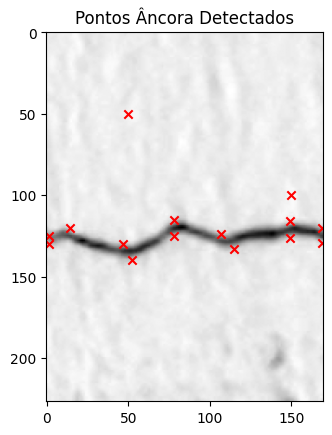

In [ ]:
import os
import cv2
import numpy as np
import heapq
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu, gaussian
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt, binary_closing, binary_opening
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Baixar dataset do Kaggle
dataset_path = kagglehub.dataset_download("oluwaseunad/concrete-and-pavement-crack-images")
image_dir = os.path.join(dataset_path, "Positive")
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise FileNotFoundError(f"Nenhuma imagem encontrada em {image_dir}")

# Carregar imagem específica
image_path = os.path.join(image_dir, image_files[0])
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Erro ao carregar {image_path}")

# Pré-processamento (Sobel + Otsu)
edges = sobel(image)
thresh_value = threshold_otsu(edges)
binary = (edges > thresh_value).astype(np.uint8) * 255

# Segmentação inicial com Watershed
distance = distance_transform_edt(binary)
local_max = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers, _ = cv2.connectedComponents(local_max.astype(np.uint8))
labels = watershed(-distance, markers, mask=binary)

# Operações morfológicas
kernel = np.ones((3, 3), np.uint8)
binary_morph = cv2.dilate(binary, kernel, iterations=1)

# Refinamento de contornos
def detect_anchor_points(image):
    edges = sobel(image)
    binary = (edges > threshold_otsu(edges)).astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    anchor_points = []
    for contour in contours:
        if len(contour) > 10:
            approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
            anchor_points.extend([(p[0][1], p[0][0]) for p in approx])

    manual_anchors = [(50, 50), (150, 100), (200, 200)]
    anchor_points.extend([(y, x) for x, y in manual_anchors if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]])

    return anchor_points

anchor_points = detect_anchor_points(image)

plt.imshow(image, cmap='gray')
plt.scatter([p[1] for p in anchor_points], [p[0] for p in anchor_points], c='r', marker='x')
plt.title("Pontos Âncora Detectados")
plt.show()
